In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import time

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation,Dropout,Input
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,Bidirectional,LSTM
from tensorflow.keras.optimizers import Adam

In [9]:
train_json=r'E:\iiit\Sem3\Information Extraction And Retrieval\major_project\data\json\train_data.json'
val_json=r'E:\iiit\Sem3\Information Extraction And Retrieval\major_project\data\json\val_data.json'

In [10]:
embedding_path='D:\datasets\glove_twitter_50_100_200\glove.twitter.27B.200d.txt'

In [ ]:
df_train=pd.read_json(train_json,orient='table')

In [ ]:
df_test=pd.read_json(val_json,orient='table')

# fit tokenizer

In [7]:
tokenizer=Tokenizer(num_words=90000)
tokenizer.fit_on_texts(df_train['clean_text'].values.tolist() + df_test['clean_text'].values.tolist())

In [8]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

603955

# save tokenizer

In [9]:
import pickle
with open('tokenizer_large.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# convert train data

In [10]:
max_length=1000

In [11]:
encoded_train=tokenizer.texts_to_sequences(df_train['clean_text'].values.tolist())

In [12]:
padded_train=pad_sequences(encoded_train,maxlen=max_length,padding='post')

In [13]:
np.save('padded_train.npy',padded_train)

In [14]:
hyperpartisan_labels_train=df_train['hyperpartisan'].values

In [15]:
bias_labels_train=df_train['bias'].values

In [16]:
np.save('hyperpartisan_labels_train.npy',hyperpartisan_labels_train)
np.save('bias_labels_train.npy',bias_labels_train)

In [13]:
max_len_in_train=0
average_length=0
for text in df_train['clean_text'].values.tolist():
    average_length+=len(text.split())
    if(len(text.split())>max_len_in_train):
        max_len_in_train=len(text.split())
print(f'maxmimum size of article in training data {max_len_in_train}')
ag=average_length/len(df_train['clean_text'].values)
print(f'Average length of article {ag}')

maxmimum size of article in training data 52696
Average length of article 582.7644516666667


# convert the test data 

In [5]:
import pickle
with open('tokenizer_large.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [6]:
df_test=pd.read_json(val_json,orient='table')

In [17]:
encoded_test=tokenizer.texts_to_sequences(df_test['clean_text'].values.tolist())

In [18]:
len(encoded_test)

150000

In [19]:
padded_test=pad_sequences(encoded_test,maxlen=max_length,padding='post')

In [20]:
np.save('padded_test.npy',padded_test)

In [21]:
hyperpartisan_labels_test=df_test['hyperpartisan'].values

In [22]:
bias_labels_test=df_test['bias'].values

In [23]:
np.save('hyperpartisan_labels_test.npy',hyperpartisan_labels_test)
np.save('bias_labels_test.npy',bias_labels_test)

# load GLoVE embeddings

In [11]:
import pickle
with open('tokenizer_large.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

vocab_size=len(tokenizer.word_index)+1

max_length=1000

In [12]:
glove_vectors={}
embedding_path='D:\datasets\glove_twitter_50_100_200\glove.twitter.27B.200d.txt'

In [13]:
%%time
file=open(embedding_path,encoding='utf-8')
for line in tqdm(file):
    values=line.split()
    word=values[0]
    vectors=np.asarray(values[1:])
    glove_vectors[word]=vectors

1193514it [00:52, 22522.82it/s]

Wall time: 53.1 s


In [14]:
embedding_matrix=np.zeros((vocab_size,200))
nalist=[]
for word,index in tokenizer.word_index.items():
    vector=glove_vectors.get(word)
    if(vector is not None):
        embedding_matrix[index]=vector
    else:
        nalist.append(word)

# Load transformed training data

In [15]:
x=np.load('padded_train.npy')

In [16]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
labels=np.load('hyperpartisan_labels_train.npy',allow_pickle=True)
le=LabelEncoder()
y=le.fit_transform(labels)

# Define the model

In [21]:
vector_size=200
model=Sequential()

model.add(Input(shape=(1000,), dtype='int32'))

model.add(Embedding(vocab_size,vector_size,input_length=max_length,weights=[embedding_matrix],trainable=False))

model.add(Conv1D(128,5,activation='relu'))
model.add(MaxPooling1D(5))

model.add(Conv1D(128,5,activation='relu'))
model.add(MaxPooling1D(5))

model.add(Conv1D(64,5,activation='relu'))
model.add(GlobalMaxPooling1D())


model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(64,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(32,activation='relu'))


model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         120791000 
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          128128    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)               

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('best_model_glove_1000.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [17]:
x,y

(array([[   57,  4597,    75, ...,     0,     0,     0],
        [    5,   956,   341, ...,     0,     0,     0],
        [ 2183,   387,  5174, ...,     0,     0,     0],
        ...,
        [    1,   259,  1065, ...,     0,     0,     0],
        [   11,     8,    32, ...,     0,     0,     0],
        [    5, 44788,  2292, ...,   176,  2368,  3410]]),
 array([1, 1, 0, ..., 0, 0, 1]))

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x,y, test_size=0.33, shuffle= True)

In [19]:
x=None
y=None 

In [23]:
history=model.fit(x_train,y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=128,callbacks=[es,mc])

Epoch 1/10
3141/3141 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.8826
Epoch 00001: val_accuracy improved from -inf to 0.91665, saving model to best_model_glove_1000.h5
3141/3141 [==============================] - 176s 56ms/step - loss: 0.2508 - accuracy: 0.8826 - val_loss: 0.1943 - val_accuracy: 0.9166
Epoch 2/10
3141/3141 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.9259
Epoch 00002: val_accuracy improved from 0.91665 to 0.92640, saving model to best_model_glove_1000.h5
3141/3141 [==============================] - 174s 55ms/step - loss: 0.1730 - accuracy: 0.9259 - val_loss: 0.1708 - val_accuracy: 0.9264
Epoch 3/10
3141/3141 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9372
Epoch 00003: val_accuracy improved from 0.92640 to 0.92856, saving model to best_model_glove_1000.h5
3141/3141 [==============================] - 175s 56ms/step - loss: 0.1487 - accuracy: 0.9372 - val_loss: 0.1648 - val_accuracy: 0.928

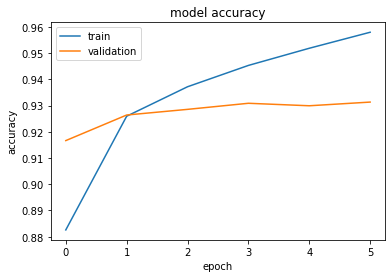

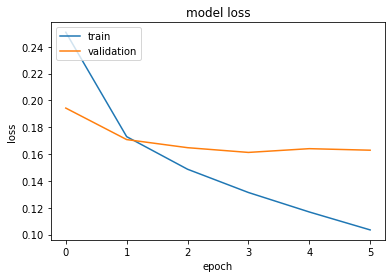

In [24]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Test the model

In [25]:
from tensorflow.keras.models import load_model
model=load_model('best_model_glove_1000.h5')

In [26]:
x_test=np.load('padded_test.npy')
y_test=le.transform(np.load('hyperpartisan_labels_test.npy',allow_pickle=True))

In [27]:
predictions=model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [28]:
from sklearn.metrics import accuracy_score,f1_score

In [29]:
y_test

array([0, 1, 1, ..., 1, 1, 0])

In [30]:
predictions

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [31]:
print(f'Accuracy Score {accuracy_score(y_test,predictions)}')
print(f'F1 Score {f1_score(y_test,predictions)}')

Accuracy Score 0.55836
F1 Score 0.6571189002298088


# test the model on articles

In [17]:
article_json=r'E:\iiit\Sem3\Information Extraction And Retrieval\major_project\data\json\by_articles.json'

In [22]:
df_article=pd.read_json(article_json).T

In [26]:
df_article.columns

Index(['hyperpartisan', 'url', 'labeled-by', 'published-at', 'title', 'text'], dtype='object')

In [28]:
encoded_article=tokenizer.texts_to_sequences(df_article['text'].values.tolist())

In [29]:
padded_article=pad_sequences(encoded_article,maxlen=max_length,padding='post')

In [30]:
y_article=le.transform(df_article['hyperpartisan'].values)

In [32]:
from tensorflow.keras.models import load_model
model=load_model('best_model_glove_1000.h5')

In [40]:
article_preds=model.predict_classes(padded_article)

In [41]:
from sklearn.metrics import accuracy_score,f1_score
print(f'Accuracy Score {accuracy_score(y_article,article_preds)}')
print(f'F1 Score {f1_score(y_article,article_preds)}')

Accuracy Score 0.5193798449612403
F1 Score 0.5799457994579945


# reverse --- train on validation data and test on train data

In [ ]:
x=np.load('padded_test.npy')

In [ ]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
labels=np.load('hyperpartisan_labels_test.npy',allow_pickle=True)
le=LabelEncoder()
y=le.fit_transform(labels)

In [19]:
vector_size=200
reverse_model=Sequential()

reverse_model.add(Input(shape=(1000,), dtype='int32'))

reverse_model.add(Embedding(vocab_size,vector_size,input_length=max_length,weights=[embedding_matrix],trainable=False))

reverse_model.add(Conv1D(128,5,activation='relu'))
reverse_model.add(MaxPooling1D(5))

reverse_model.add(Conv1D(128,5,activation='relu'))
reverse_model.add(MaxPooling1D(5))

reverse_model.add(Conv1D(64,5,activation='relu'))
reverse_model.add(GlobalMaxPooling1D())


reverse_model.add(Dense(128,activation='relu'))
reverse_model.add(Dropout(0.4))


reverse_model.add(Dense(64,activation='relu'))
reverse_model.add(Dropout(0.4))

reverse_model.add(Dense(32,activation='relu'))


reverse_model.add(Dense(1,activation='sigmoid'))

reverse_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [13]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x,y, test_size=0.2, shuffle= True)

In [14]:
x=None
y=None

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
res = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
rmc = ModelCheckpoint('reverse_best_model_glove_1000.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [20]:
history=reverse_model.fit(x_train,y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64,callbacks=[res,rmc])

Epoch 1/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.4066 - accuracy: 0.7889
Epoch 00001: val_accuracy improved from -inf to 0.85253, saving model to reverse_best_model_glove_1000.h5
1875/1875 [==============================] - 54s 29ms/step - loss: 0.4065 - accuracy: 0.7890 - val_loss: 0.3118 - val_accuracy: 0.8525
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.2789 - accuracy: 0.8750
Epoch 00002: val_accuracy improved from 0.85253 to 0.87500, saving model to reverse_best_model_glove_1000.h5
1875/1875 [==============================] - 54s 29ms/step - loss: 0.2789 - accuracy: 0.8750 - val_loss: 0.2770 - val_accuracy: 0.8750
Epoch 3/10
1873/1875 [============================>.] - ETA: 0s - loss: 0.2313 - accuracy: 0.8990
Epoch 00003: val_accuracy improved from 0.87500 to 0.87980, saving model to reverse_best_model_glove_1000.h5
1875/1875 [==============================] - 54s 29ms/step - loss: 0.2313 - accuracy: 0.8990 - val_loss: 0.2709 

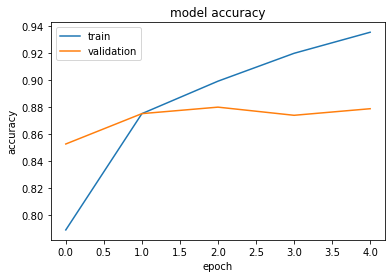

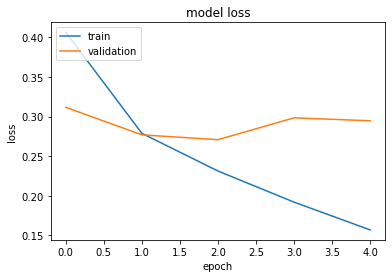

In [22]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
# reverse_model.save('reverse_glove_1000.h5')

# reverse test

In [23]:
from tensorflow.keras.models import load_model
reverse_model=load_model('reverse_best_model_glove_1000.h5')

In [24]:
x_test=np.load('padded_train.npy')
y_test=le.transform(np.load('hyperpartisan_labels_train.npy',allow_pickle=True))

In [25]:
predictions=reverse_model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [26]:
from sklearn.metrics import accuracy_score,f1_score

In [27]:
print(f'Accuracy Score {accuracy_score(y_test,predictions)}')
print(f'F1 Score {f1_score(y_test,predictions)}')

Accuracy Score 0.5752616666666667
F1 Score 0.6001126650943767


# Bias detection

In [9]:
x=np.load('padded_train.npy')

In [10]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
labels=np.load('bias_labels_train.npy',allow_pickle=True)
le_bias=LabelEncoder()
y=le_bias.fit_transform(labels)

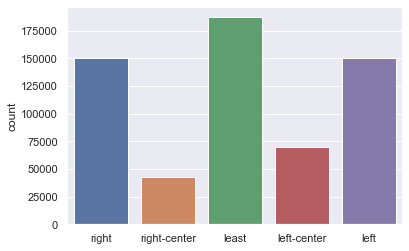

In [11]:
import seaborn as sns
sns.set()
sns.countplot(labels)

In [12]:
np.unique(y,return_counts=True)

(array([0, 1, 2, 3, 4]),
 array([187114, 150000,  70053, 150000,  42833], dtype=int64))

In [13]:
le_bias.classes_

array(['least', 'left', 'left-center', 'right', 'right-center'],
      dtype=object)

In [14]:
from tensorflow import keras

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.92)

In [15]:
vector_size=200
bias_model=Sequential()

bias_model.add(Input(shape=(1000,), dtype='int32'))

bias_model.add(Embedding(vocab_size,vector_size,input_length=max_length,weights=[embedding_matrix],trainable=False))

bias_model.add(Conv1D(128,5,activation='relu'))
bias_model.add(MaxPooling1D(5))

bias_model.add(Conv1D(128,5,activation='relu'))
bias_model.add(MaxPooling1D(5))

bias_model.add(Conv1D(64,5,activation='relu'))
bias_model.add(GlobalMaxPooling1D())


bias_model.add(Dense(128,activation='relu'))
bias_model.add(Dropout(0.4))


bias_model.add(Dense(64,activation='relu'))
bias_model.add(Dropout(0.4))

bias_model.add(Dense(32,activation='relu'))


bias_model.add(Dense(5,activation='sigmoid'))

bias_model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [16]:
bias_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 200)         120791000 
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 64)            41024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x,y, test_size=0.2, shuffle= True,stratify=y)

In [18]:
x=None
y=None

In [19]:
x_train.shape

(480000, 1000)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [21]:
bes = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
bmc = ModelCheckpoint('bias_best_model_glove_1000.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [22]:
history=bias_model.fit(x_train,y_train,validation_data=(x_valid,y_valid),epochs=20,batch_size=128,callbacks=[bes,bmc])

Epoch 1/20
3750/3750 [==============================] - ETA: 0s - loss: 0.7982 - accuracy: 0.6835
Epoch 00001: val_accuracy improved from -inf to 0.81630, saving model to bias_best_model_glove_1000.h5
3750/3750 [==============================] - 185s 49ms/step - loss: 0.7982 - accuracy: 0.6835 - val_loss: 0.4947 - val_accuracy: 0.8163
Epoch 2/20
3750/3750 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.8250
Epoch 00002: val_accuracy improved from 0.81630 to 0.83683, saving model to bias_best_model_glove_1000.h5
3750/3750 [==============================] - 187s 50ms/step - loss: 0.4745 - accuracy: 0.8250 - val_loss: 0.4340 - val_accuracy: 0.8368
Epoch 3/20
3749/3750 [============================>.] - ETA: 0s - loss: 0.4112 - accuracy: 0.8503
Epoch 00003: val_accuracy improved from 0.83683 to 0.85920, saving model to bias_best_model_glove_1000.h5
3750/3750 [==============================] - 185s 49ms/step - loss: 0.4111 - accuracy: 0.8503 - val_loss: 0.3813 - val_

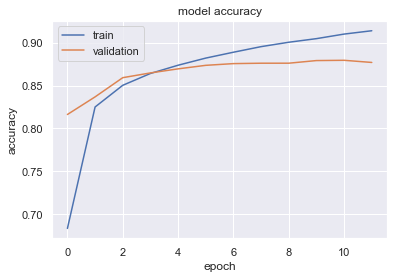

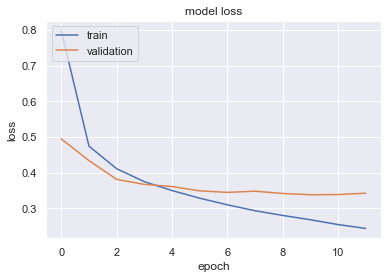

In [24]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
bias_model.save('bias_glove_1000.h5')

# test

In [25]:
from tensorflow.keras.models import load_model
bias_model=load_model('bias_best_model_glove_1000.h5')

In [26]:
x_test=np.load('padded_test.npy')
y_test=le_bias.transform(np.load('bias_labels_test.npy',allow_pickle=True))

In [27]:
ynp=np.load('bias_labels_test.npy',allow_pickle=True)

In [28]:
predictions=bias_model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [29]:
from sklearn.metrics import accuracy_score,f1_score

In [34]:
print(f'Accuracy Score {accuracy_score(y_test,predictions)}')
print(f'F1 Score')

Accuracy Score 0.3099133333333333
F1 Score


In [35]:
f1_score(y_test,predictions,average='weighted')

0.28923609302173886

In [32]:
np.unique(y_test,return_counts=True)

(array([0, 1, 2, 3, 4]),
 array([38296, 37500, 23473, 37500, 13231], dtype=int64))

In [33]:
np.unique(predictions,return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([12255, 77218, 25426, 30787,  4314], dtype=int64))

In [36]:
le_bias.inverse_transform([0])

array(['least'], dtype=object)

In [37]:
le_bias.inverse_transform([1])

array(['left'], dtype=object)

In [38]:
le_bias.inverse_transform([2])

array(['left-center'], dtype=object)

In [39]:
le_bias.inverse_transform([3])

array(['right'], dtype=object)

In [40]:
le_bias.inverse_transform([4])

array(['right-center'], dtype=object)